## Overview

This Jupyter notebook focuses on preprocessing a house sale data before training a ML model for house prices predicton. This will include handling missing values and performing necessary data transformations.

## Dataset Information

The dataset used in this analysis contains real estate listings in the US broken by State and zip code, downloaded from https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset



In [1]:
import numpy as np
from scipy.stats import skew
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [3]:
df = pd.read_csv('realtor-data.csv')
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904966 entries, 0 to 904965
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          904966 non-null  object 
 1   bed             775126 non-null  float64
 2   bath            791082 non-null  float64
 3   acre_lot        638324 non-null  float64
 4   city            904894 non-null  object 
 5   state           904966 non-null  object 
 6   zip_code        904762 non-null  float64
 7   house_size      612080 non-null  float64
 8   prev_sold_date  445865 non-null  object 
 9   price           904895 non-null  float64
dtypes: float64(6), object(4)
memory usage: 69.0+ MB


#### Numerical and Categorical Features

In [5]:
# Identify Numerical and Categorical Features

numerical_columns = df.select_dtypes(include=['number']).columns
numerical_variables = numerical_columns.tolist()
print("Numerical Features Count:", len(numerical_variables))
print("Numerical Features:", numerical_variables)

categorical_columns = df.select_dtypes(include=['object']).columns
categorical_variables = categorical_columns.tolist()
print("Categorical Features Count:", len(categorical_variables))
print("Categorical Features:", categorical_variables)

Numerical Features Count: 6
Numerical Features: ['bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'price']
Categorical Features Count: 4
Categorical Features: ['status', 'city', 'state', 'prev_sold_date']


In [6]:
#View statistical properties of categorical variables
categorical_summary = df[categorical_columns].describe()
categorical_summary

,status,city,state,prev_sold_date
count,904966,904894,904966,445865
unique,2,2487,18,9870
top,for_sale,New York City,New Jersey,2018-07-25
freq,903373,47502,231958,317


In [8]:
#View statistical properties of numerical variables
numerical_summary = df[numerical_columns].describe()
numerical_summary

,bed,bath,acre_lot,zip_code,house_size,price
count,775126.000000,791082.000000,638324.000000,904762.000000,6.120800e+05,9.048950e+05
mean,3.332190,2.484236,17.317292,6519.464582,2.138437e+03,8.774382e+05
std,2.065312,1.931622,970.707378,3816.713093,3.046600e+03,2.457698e+06
min,1.000000,1.000000,0.000000,601.000000,1.000000e+02,0.000000e+00
25%,2.000000,2.000000,0.110000,2908.000000,1.132000e+03,2.685000e+05
50%,3.000000,2.000000,0.290000,6811.000000,1.650000e+03,4.750000e+05
75%,4.000000,3.000000,1.150000,8854.000000,2.495000e+03,8.300000e+05
max,123.000000,198.000000,100000.000000,99999.000000,1.450112e+06,8.750000e+08


#### Duplicates and Misisng Values

In [9]:
# Missing values in numerical variables
for col in numerical_columns:
    missing_count = df[col].isnull().sum()
    missing_percentage = (missing_count / len(df[col])) * 100
    print(f"{col}: {missing_count} missing values ({missing_percentage:.2f}%)")

bed: 129840 missing values (14.35%)
bath: 113884 missing values (12.58%)
acre_lot: 266642 missing values (29.46%)
zip_code: 204 missing values (0.02%)
house_size: 292886 missing values (32.36%)
price: 71 missing values (0.01%)


In [7]:
# Missing values in categorical variables
for col in categorical_columns:
    missing_count = df[col].isnull().sum()
    missing_percentage = (missing_count / len(df[col])) * 100
    print(f"{col}: {missing_count} missing values ({missing_percentage:.2f}%)")

status: 0 missing values (0.00%)
city: 72 missing values (0.01%)
state: 0 missing values (0.00%)
prev_sold_date: 459101 missing values (50.73%)


In [10]:
print('number of duplicates:',df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.shape

number of duplicates: 794865


(110101, 10)

In [11]:
nulls = df.isnull().sum()
fig = px.bar(y=nulls.index, x=nulls.values, text=nulls.values, orientation='h', height=400, width=600)
fig.update_layout(yaxis_title="Variables", xaxis_title="Null Counts")
fig.update_xaxes(range=[0, len(df)])
fig.show()

In [12]:
# Drop rows with missing values in the target variable
df.dropna(subset=['price'], inplace=True)

# Fill missing values with mode 
df['bed'].fillna(df['bed'].mode()[0], inplace=True)
df['bath'].fillna(df['bath'].mode()[0], inplace=True)

which_method = 1
if which_method == 1: # Fill missing values with mode 
    df['acre_lot'].fillna(df['acre_lot'].mode()[0], inplace=True)
    df['house_size'].fillna(df['house_size'].mode()[0], inplace=True)
elif which_method == 2: # Use KNeighborsRegressor for imputing missing values
    features_to_impute = ['acre_lot', 'house_size']
    scaler = StandardScaler()
    df[features_to_impute] = scaler.fit_transform(df[features_to_impute])
    knn_imputer = KNNImputer(n_neighbors=5, n_jobs=-1)
    df[features_to_impute] = knn_imputer.fit_transform(df[features_to_impute])
else:
    raise ValueError("Invalid method: {}".format(which_method))

# Drop some rows with missing values
df.dropna(subset=['zip_code', 'city'], inplace=True)

# Drop the irrelevant features (it has more than 50% missing values)
df.drop('prev_sold_date', axis=1, inplace=True)

# Verify that missing values are imputed
print("Number of missing values after imputing:")
print(df.isnull().sum())


Number of missing values after imputing:
status        0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
price         0
dtype: int64


#### Outliers

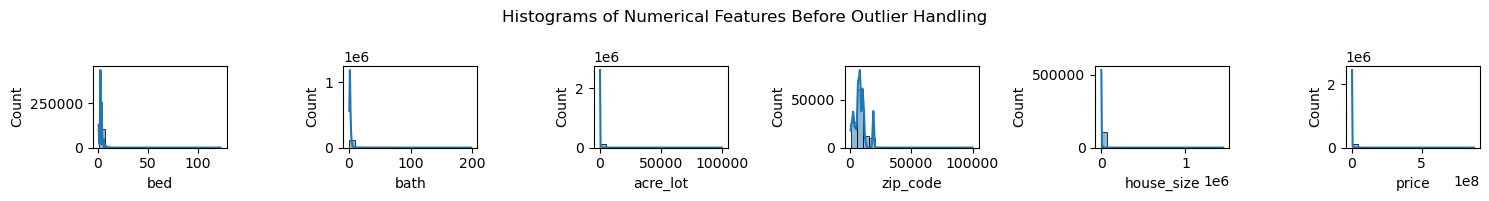

In [13]:
# Plot histograms of numerical features

plt.figure(figsize=(15, 2))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1,6,i)
    sns.histplot(df[column], kde=True, bins=20)
plt.suptitle('Histograms of Numerical Features Before Outlier Handling')    
plt.tight_layout()
plt.show()

In [14]:
#To check for skew in data:
df[numerical_columns].skew().sort_values(ascending=False)

house_size    240.819629
price         151.844221
acre_lot      107.671049
bath           23.223767
bed             9.635381
zip_code        1.057259
dtype: float64

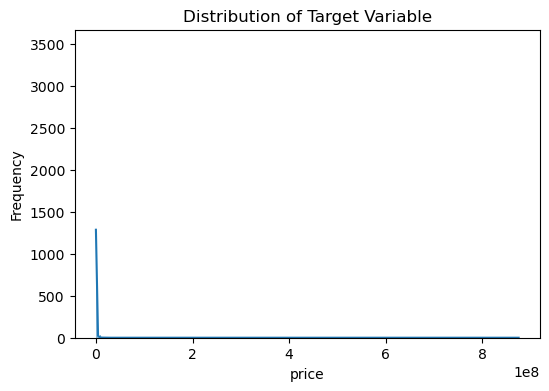

the skewness of the target data: 151.84422085183274


In [15]:
#Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.histplot(df['price'], kde=True)
plt.title(f'Distribution of Target Variable')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

print('the skewness of the target data:', df['price'].skew())


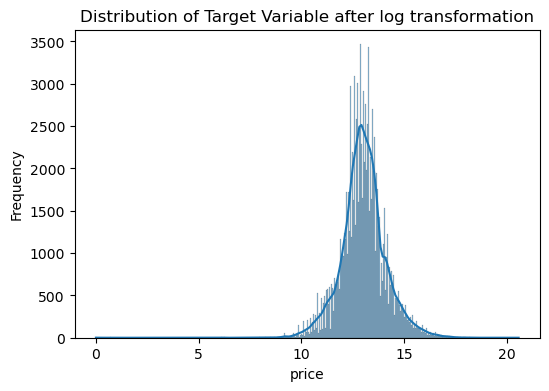

the skewness of the target data: -0.014732922848544055


In [16]:
#Apply log transformation to skewed distribution
df['price'] = df['price'].apply(lambda x: np.log1p(x))

plt.figure(figsize=(6, 4))
sns.histplot(df['price'], kde=True)
plt.title(f'Distribution of Target Variable after log transformation')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

print('the skewness of the target data:', df['price'].skew())

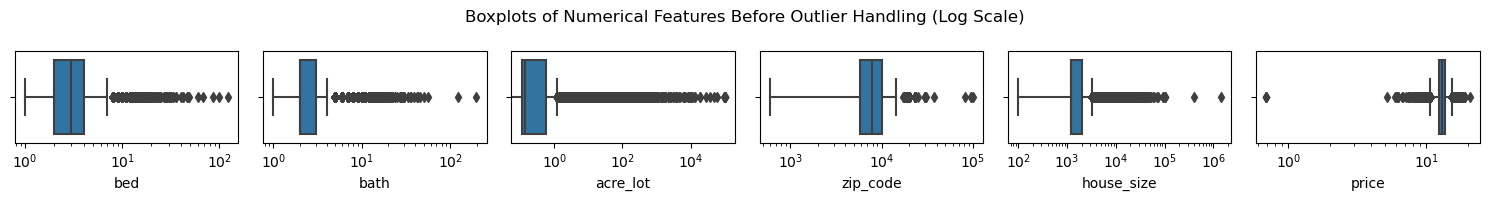

In [17]:
# Plot boxplots for numerical features

numerical_columns = ['bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'price']

plt.figure(figsize=(15, 2))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1,6,i)
    sns.boxplot(x=df[column])
    plt.xscale('log') 
plt.suptitle('Boxplots of Numerical Features Before Outlier Handling (Log Scale)')    
plt.tight_layout()
plt.show()



In [18]:
# Apply IQR method 

outlier_percentage = {}
upper_threshold = {}
lower_threshold = {}
for variable in numerical_columns:
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    upper_threshold[variable] = Q3 + 1.5 * IQR
    lower_threshold[variable] = Q1 - 1.5 * IQR
    
    # Count the number and percentage of outliers
    num_upper_outliers = sum(df[variable] > upper_threshold[variable])
    num_lower_outliers = sum(df[variable] < lower_threshold[variable])
    total_outliers = num_upper_outliers + num_lower_outliers
    total_data_points = len(df)
    percentage_outliers = (total_outliers / total_data_points) * 100
    outlier_percentage[variable] = percentage_outliers

print("Percentage of outliers for each variable:")
for variable, percentage in outlier_percentage.items():
    print(f"{variable}: {percentage:.2f}%")


Percentage of outliers for each variable:
bed: 2.07%
bath: 6.50%
acre_lot: 16.27%
zip_code: 9.32%
house_size: 8.90%
price: 4.62%


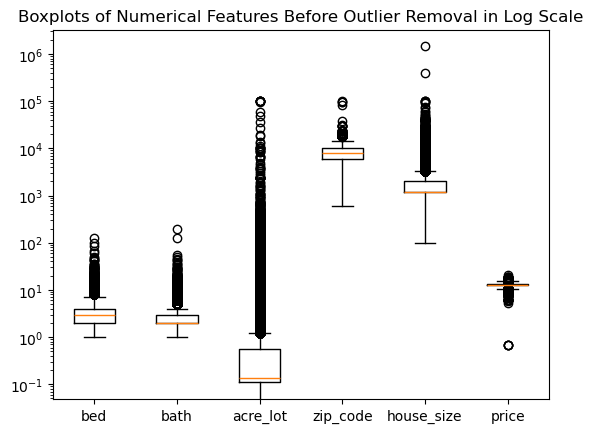

In [19]:
plt.boxplot(df[numerical_columns])
plt.xticks(range(1, len(numerical_columns) + 1),numerical_columns)
plt.yscale('log')
plt.title('Boxplots of Numerical Features Before Outlier Removal in Log Scale')
plt.show()

In [20]:
#Outliers Removal (IQR method)

columns = ['bed', 'bath', 'acre_lot', 'zip_code', 'house_size','price']
for variable in columns:
    df.drop(df[df[variable] <= lower_threshold[variable]].index, axis=0, inplace=True)
    df.drop(df[df[variable] >= upper_threshold[variable]].index, axis=0, inplace=True)


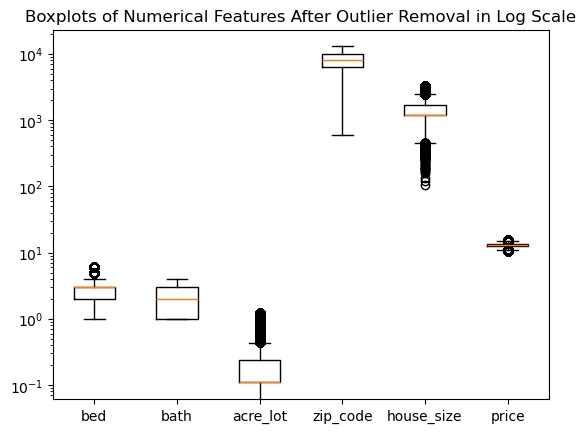

In [21]:
plt.boxplot(df[numerical_columns])
plt.xticks(range(1, len(numerical_columns) + 1),numerical_columns)
plt.yscale('log')
plt.title('Boxplots of Numerical Features After Outlier Removal in Log Scale')
plt.show()

In [22]:
#To check for skew in data:
df[numerical_columns].skew().sort_values(ascending=False)

acre_lot      2.228980
house_size    1.093579
bath          0.427850
bed           0.370014
price         0.028837
zip_code     -0.645706
dtype: float64

In [23]:
df.describe(include='all')

,status,bed,bath,acre_lot,city,state,zip_code,house_size,price
count,70708,70708.000000,70708.000000,70708.000000,70708,70708,70708.000000,70708.000000,70708.000000
unique,2,NaN,NaN,NaN,2033,11,NaN,NaN,NaN
top,for_sale,NaN,NaN,NaN,New York City,New Jersey,NaN,NaN,NaN
freq,70531,NaN,NaN,NaN,5335,25593,NaN,NaN,NaN
mean,NaN,2.872122,2.076385,0.227906,NaN,NaN,7404.475816,1441.236536,13.018682
std,NaN,1.124706,0.856371,0.242642,NaN,NaN,3013.937266,563.494039,0.828787
min,NaN,1.000000,1.000000,0.000000,NaN,NaN,601.000000,104.000000,10.689123
25%,NaN,2.000000,1.000000,0.110000,NaN,NaN,6249.000000,1200.000000,12.506181
50%,NaN,3.000000,2.000000,0.110000,NaN,NaN,7960.000000,1200.000000,13.014780
75%,NaN,3.000000,3.000000,0.240000,NaN,NaN,10019.000000,1700.000000,13.526496


In [24]:
#export the preprocessed data to a CSV file
df.to_csv("Preprocessed_Data.csv", index=False)